# Figure 4 (Combined dataset)

In [1]:
from mol2ccs.utils import performance_evaluation
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
import numpy as np
from utils import SeabornFig2Grid

from scipy.stats import linregress
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

In [2]:
plt.rcParams["figure.dpi"] = 500

In [3]:
pd.options.mode.copy_on_write = True

In [5]:
mol2ccs_preds = pd.read_parquet(
    "ccs-prediction-outputs/final-experiments-paper/mol2ccs/metlin_ccsbase_test_3d_pred.parquet"
)

graphccs_pred = pd.read_parquet(
    "ccs-prediction-outputs/final-experiments-paper/graphccs/v2-graphccs-combined-test-predictions.parquet"
)

sigmaccs_pred = pd.read_parquet(
    "ccs-prediction-outputs/final-experiments-paper/sigmaccs-old/results/metlin_ccsbase_test_3d_pred.parquet"
)

In [6]:
sigmaccs_pred

,smiles,adduct,ccs,Predicted CCS
0,O=C(NCc1ccc(cc1)F)NCCCN1CCc2c1cccc2,[M+H]+,176.63,182.136887
1,O=C(N1CCN(CC1)S(=O)(=O)Cc1ccccc1)CN1C(=O)NC2(C...,[M+H]+,204.22,206.944229
2,Cc1ccc(cc1)n1nnnc1SCC(=O)N(c1ccc2c(c1)OCCO2)Cc...,[M+H]+,215.24,214.094391
3,O=C(N1CCN(CC1)S(=O)(=O)Cc1ccccc1)CSc1nnc(n1c1c...,[M+H]+,228.78,227.747635
4,Clc1ccc(cc1)S(=O)(=O)c1nc(oc1SCc1ccccc1F)c1ccco1,[M+H]+,192.54,198.353561
...,...,...,...,...
12477,C1=NC2=C(N1[C@H]3[C@@H]([C@@H]([C@H](O3)CO)O)O...,[M+K]+,174.90,177.844040
12478,O=C1OC[C@@H]2[C@H](O)c3cc4c(cc3[C@@H](c3cc(O)c...,[M+H]+,147.60,176.842438
12479,CC(=O)ONc1cccc2c[nH]nc12,[M+Na]+,138.10,145.607666
12480,C=C(CN(C)C)[C@@H](CC)c1cccc(O)c1,[M+H]+,149.60,149.210373


Ensure that the predictions are in the same order as the test set

In [7]:
evaluation_dict = {}
predictions_dict = {}

for i, preds in enumerate(
    [
        mol2ccs_preds,
        graphccs_pred,
        sigmaccs_pred,
    ]
):
    # Model name based on the order of the preds
    name = [
        "Combined dataset Mol2CCS",
        "Combined dataset GraphCCS",
        "Combined dataset SigmaCCS",
    ][i]

    if "mol2ccs" in name.lower():
        model = "mol2ccs"
        experimental_values = preds["ccs"].values
        predictions = preds["pred_ccs"].values

    elif "graphccs" in name.lower():
        model = "graphccs"
        experimental_values = preds["Label"].values
        predictions = preds["predict"].values

    else:
        model = "sigmaccs"
        experimental_values = preds["ccs"].values
        predictions = preds["Predicted CCS"].values

    evaluation_dict[model] = performance_evaluation(
        predictions, experimental_values, verbose=False
    )[0]

    predictions_dict[model] = (experimental_values, predictions)

In [8]:
evaluation_dict[model].head(10)

,Metric,Value
0,MAE,4.404832
1,MSE,36.540999
2,RMSE,6.044915
3,R2,0.949955
4,Mean Percent RSD,2.254805
5,Median Percent RSD,1.711022
6,Max Percent RSD,34.043878
7,Min Percent RSD,0.000174
8,Pearson's correlation,0.974657
9,Spearman's correlation,0.953764


In [9]:
def calculate_metrics(x, y):

    mae_original = mean_absolute_error(x, y)
    rmse_original = root_mean_squared_error(x, y)
    r2_original = linregress(x, y).rvalue ** 2

    # median relative error in %
    median_relative_error_original = x - y
    # Absolute value
    median_relative_error_original = (
        np.abs(median_relative_error_original) / np.array(x) * 100
    )

    # Get the median
    median_relative_error_original = np.median(median_relative_error_original)

    return mae_original, rmse_original, r2_original, median_relative_error_original


# Make a function to plot the scatter plot for each model
def plot_scatter(
    x: np.array,
    y: np.array,
    color,
    model_name: str,
    alpha: float = 0.2,
    size: int = 10,
    x_label: bool = True,
    y_label: bool = True,
):

    g = sns.jointplot(
        x=x,
        y=y,
        # add transparency to the points
        alpha=alpha,
        s=size,
        color=color,
    )

    # set title
    g.fig.suptitle(f"Scatter plot of {model_name} predictions")

    # Add a line to show the perfect correlation
    g.ax_joint.plot(
        [x.min(), y.max()],
        [x.min(), y.max()],
        "k--",
        lw=2,
    )

    g.ax_joint.set_xlabel("Experimental CCS", fontsize=16)
    g.ax_joint.set_ylabel(f"Predicted CCS", fontsize=16)

    if x_label is False:
        g.ax_joint.set_xlabel("")
        # no ticks
        g.ax_joint.set_xticks([])

    if y_label is False:
        g.ax_joint.set_ylabel("")
        g.ax_joint.set_yticks([])

    mae, rmse, r2, mre = calculate_metrics(x, y)

    g.ax_joint.text(
        0.05,
        0.95,
        f"n={len(x):,}\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR2: {r2:.2f}\nMRE: {mre:.2f}%",
        horizontalalignment="left",
        verticalalignment="top",
        transform=g.ax_joint.transAxes,
        fontsize=12,
    )

    return g

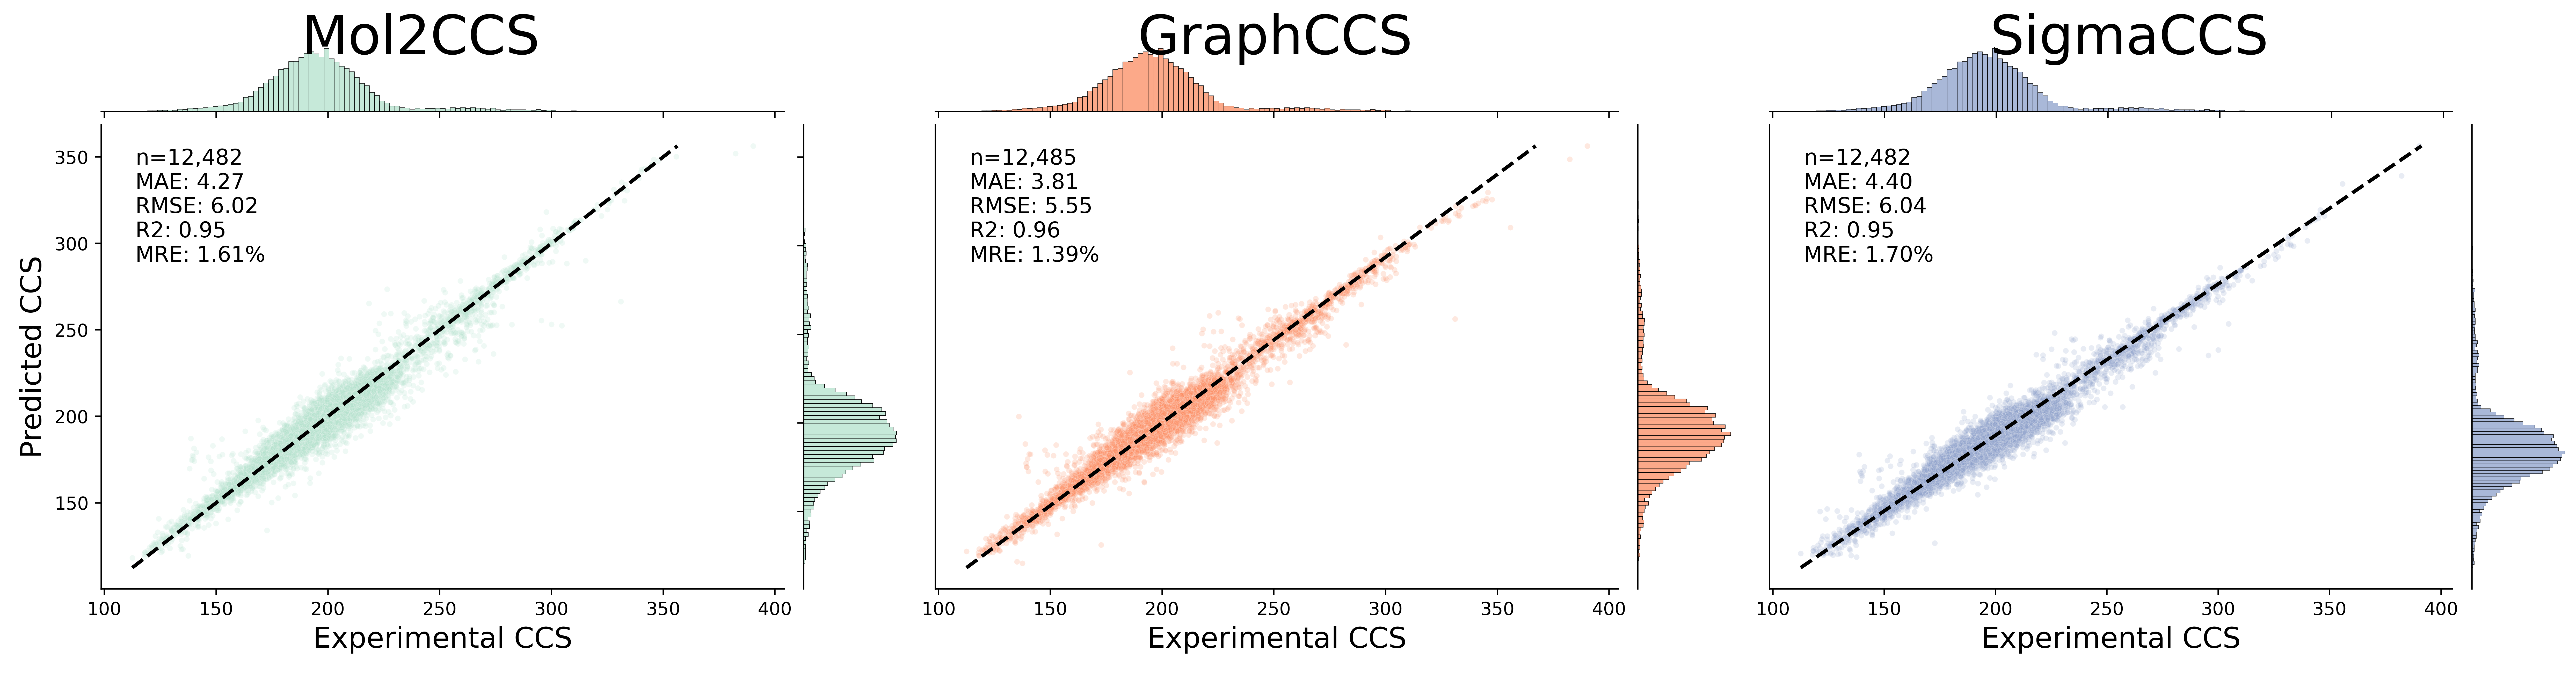

In [10]:
fig = plt.figure(figsize=(20, 5))
gs = gridspec.GridSpec(1, 3)

palette = {
    "Mol2CCS": "#b3e2cd",
    "GraphCCS": "#fc8d62",
    "Sigmaccs": "#8da0cb",
}

# Mol2CCS is the first column, GraphCCS is the second column, and Sigmaccs is the third column

# First row
_ = SeabornFig2Grid(
    plot_scatter(
        x=predictions_dict["mol2ccs"][0],
        y=predictions_dict["mol2ccs"][1],
        model_name="Mol2CCS",
        color=palette["Mol2CCS"],
        x_label=True,
    ),
    fig,
    gs[0],
)

# GraphCCS
_ = SeabornFig2Grid(
    plot_scatter(
        x=predictions_dict["graphccs"][0],
        y=predictions_dict["graphccs"][1],
        model_name="GraphCCS",
        color=palette["GraphCCS"],
        x_label=True,
        y_label=False,
    ),
    fig,
    gs[1],
)

# Sigmaccs
_ = SeabornFig2Grid(
    plot_scatter(
        x=predictions_dict["sigmaccs"][0],
        y=predictions_dict["sigmaccs"][1],
        model_name="Sigmaccs",
        color=palette["Sigmaccs"],
        x_label=True,
        y_label=False,
    ),
    fig,
    gs[2],
)

# Add a super title in each column
for i, title in enumerate(
    [
        "Mol2CCS",
        "GraphCCS",
        "SigmaCCS",
    ]
):
    fig.text(
        0.5 * (0.33 * i + 0.33 * (i + 1)),
        1.03,
        title,
        horizontalalignment="center",
        verticalalignment="top",
        fontsize=30,
    )


gs.tight_layout(fig)
plt.savefig("figure_4.png", dpi=500, bbox_inches="tight")

plt.show()